In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob

### Step 1. Collect the Dataset

In [11]:
df =pd.read_csv('Tweets_unlabelled.csv')
df.head()

,textID,text,selected_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD
2,088c60f138,my boss is bullying me...,bullying me
3,9642c003ef,what interview! leave me alone,leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,"


### Step 2. Label the Dataset (semi-supervised)

In [12]:
subset = df.head(1000).copy()

In [13]:
subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         1000 non-null   object
 1   text           999 non-null    object
 2   selected_text  999 non-null    object
dtypes: object(3)
memory usage: 23.6+ KB


In [14]:
subset['selected_text'] = subset['selected_text'].fillna('').astype(str)

def get_sentiment(text):
    analysis = TextBlob(text)
    return 1 if analysis.sentiment.polarity > 0 else 0

subset['label'] = subset['selected_text'].apply(get_sentiment)

In [15]:
subset.tail()

,textID,text,selected_text,label
995,7c7a445b8d,"I am twittering, LIKE A BOSS. Thanks Savvv",Thanks Savvv,1
996,fe6301dd3a,my sleep pattern is screwed i need to try and...,my sleep pattern is screwed,0
997,fd98097a71,Since the demise of Woolworths it isn`t easy ...,isn`t easy to find,1
998,a7b4ba7093,may the fourth be with you! happy star wars day,may the fourth be with you! happy star wars day,1
999,6d2170e60f,I`ve been unlocked for decades now...just not...,".just not lucky, never have been.",0


### Step 3. Preprocessing

In [16]:
import re

In [17]:
# Remove URLs
subset['selected_text'] = subset['selected_text'].apply(lambda x: re.sub(r'http\s+', '', x))

In [18]:
# Remove mentions
subset['selected_text'] = subset['selected_text'].apply(
    lambda x: re.sub(r'@[A-Za-z0-9_]+', '', x) if isinstance(x, str) else x
)

In [19]:
# Remove hashtags
subset['selected_text'] = subset['selected_text'].apply(
    lambda x: re.sub(r'#\w+', '', x) if isinstance(x, str) else x
)

In [20]:
# Remove special characters
subset['selected_text'] = subset['selected_text'].apply(
    lambda x: re.sub(r'[^A-Za-z0-9\s]', '', x) if isinstance(x, str) else x
)

In [21]:
# Convert to lowercase
subset['selected_text'] = subset['selected_text'].apply(
    lambda x: x.lower() if isinstance(x, str) else x
)

### Step 4. Data Preparation

In [22]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
# Remove stopwords and tolenize text
stop_words = set(stopwords.words('english'))

def remove_stopwords_and_tokenize(text):
    if isinstance(text, str):
        tokens = word_tokenize(text)
        filtered = [word for word in tokens
                    if word.lower() not in stop_words and word not in string.punctuation]
        return filtered
    return text

subset['selected_text'] = subset['selected_text'].apply(remove_stopwords_and_tokenize)

In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [25]:
# Flatten all token lists to fit tokenizer on all words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(subset['selected_text'])  # subset['selected_text'] is a list of tokens per row

# Convert token lists to sequences of integers
sequences = tokenizer.texts_to_sequences(subset['selected_text'])

In [26]:
max_len = 20  # fixed length
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

In [28]:
print(type(padded_sequences))

<class 'numpy.ndarray'>


### Step 5. Model Building

In [29]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [32]:
label = subset['label']

In [33]:
# Split into train and test sets (e.g., 80/20)
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, label, test_size=0.2, random_state=42)

In [34]:
vocab_size = len(tokenizer.word_index) + 1
max_len = padded_sequences.shape[1]

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    SimpleRNN(64, return_sequences=False),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [35]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Step 6. Train the Model

In [36]:
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.6360 - loss: 0.6574 - val_accuracy: 0.6350 - val_loss: 0.6401
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7826 - loss: 0.5033 - val_accuracy: 0.7500 - val_loss: 0.5272
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9701 - loss: 0.1018 - val_accuracy: 0.8000 - val_loss: 0.5614
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9881 - loss: 0.0522 - val_accuracy: 0.7400 - val_loss: 0.6910
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9988 - loss: 0.0137 - val_accuracy: 0.7500 - val_loss: 0.6547


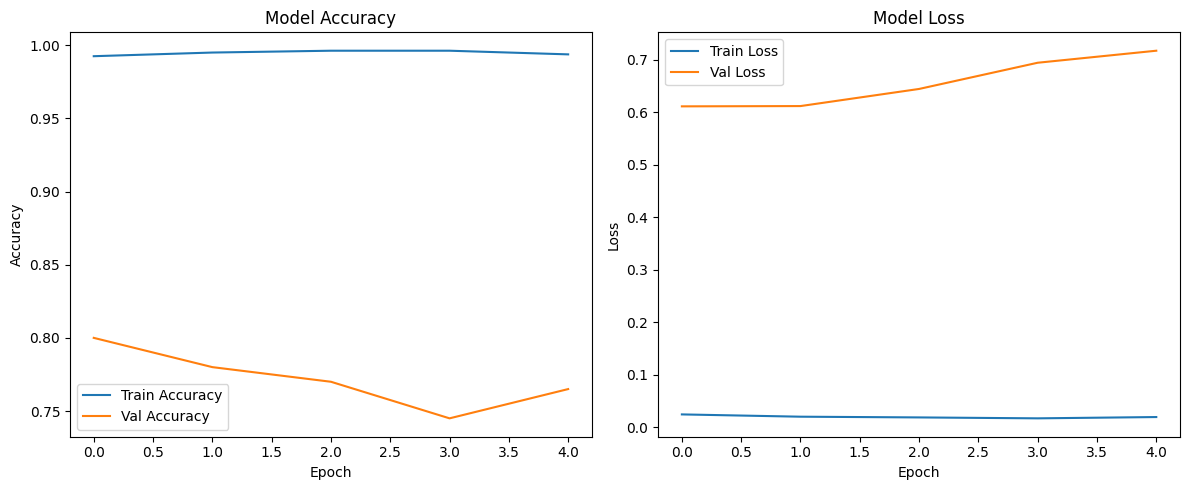

In [38]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show();

### Step 7. Evaluate the Model

In [39]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7619 - loss: 0.7076 
Test Accuracy: 0.76


In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       121
           1       0.68      0.77      0.72        79

    accuracy                           0.77       200
   macro avg       0.76      0.77      0.76       200
weighted avg       0.77      0.77      0.77       200



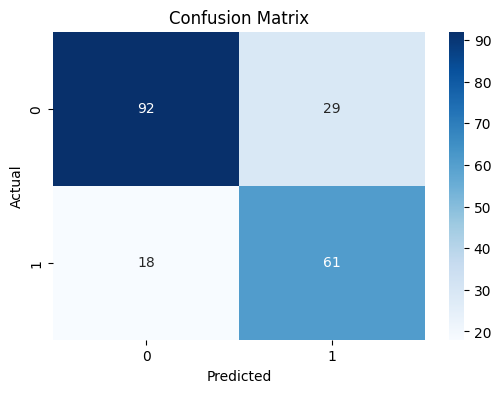

In [41]:
# Step 1: Get predicted probabilities
y_pred_probs = model.predict(X_test)

# Step 2: Convert to binary predictions (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Step 3: Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 4: Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show();

### Step 8. Make a Prediction Function

In [42]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and punctuation
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]

    return tokens

def predict_sentiment(text):
    # Preprocess input
    tokens = preprocess_text(text)

    # Convert tokens to sequence
    sequence = tokenizer.texts_to_sequences([tokens])

    # Pad the sequence
    padded = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # Predict
    prob = model.predict(padded)[0][0]
    label = 1 if prob > 0.5 else 0

    # Output
    sentiment = 'Positive' if label == 1 else 'Negative'
    print(f"Tweet: {text}")
    print(f"Predicted Sentiment: {sentiment} (Probability: {prob:.2f})")
    return sentiment

In [46]:
predict_sentiment("This is the best experience I've ever had.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tweet: This is the best experience I've ever had.
Predicted Sentiment: Positive (Probability: 1.00)


'Positive'